In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/data/NLP/ruijin_round1_train2_20181022.zip
!pip install git+https://www.github.com/keras-team/keras-contrib.git

天池-瑞金医院MMC人工智能辅助构建知识图谱大赛复赛

# 1. data_utils

In [ ]:
import os
import math
import numpy as np
from collections import Counter, defaultdict
from itertools import groupby
from spacy import displacy


ENTITIES = [
    "Amount", "Anatomy", "Disease", "Drug",
    "Duration", "Frequency", "Level", "Method",
    "Operation", "Reason", "SideEff", "Symptom",
    "Test", "Test_Value", "Treatment"
]
COLORS = [
    '#7aecec','#bfeeb7','#feca74','#ff9561',
    '#aa9cfc','#c887fb','#9cc9cc','#ffeb80',
    '#ff8197','#ff8197','#f0d0ff','#bfe1d9',
    '#bfe1d9','#e4e7d2','#e4e7d2','#e4e7d2',
    '#e4e7d2','#e4e7d2'
]
COLOR_MAP = dict(zip([ent.upper() for ent in ENTITIES], COLORS[:len(ENTITIES)]))


class Sentence(object):
    def __init__(self, doc_id, offset, text, ents):
        self.text = text
        self.doc_id = doc_id
        self.offset = offset
        self.ents = ents

    def __repr__(self):
        return self.text

    def __gt__(self, other):
        return self.offset > other.offset

    def __getitem__(self, key):
        if isinstance(key, int):
            return self.text[key]
        if isinstance(key, slice):
            text = self.text[key]
            start = key.start or 0
            stop = key.stop or len(self.text)
            if start < 0:
                start += len(self.text)
            if stop < 0:
                stop += len(self.text)

            ents = self.ents.find_entities(start, stop).offset(-start)
            offset = self.offset + start
            return Sentence(self.doc_id, offset, text, ents)

    def _repr_html_(self):
        ents = []
        for ent in self.ents:
            ents.append({'start': ent.start_pos,
                         'end': ent.end_pos,
                         'label': ent.category})
        ex = {'text': self.text, 'ents': ents, 'title': None}
        return displacy.render(ex,
                               style='ent',
                               options={'colors': COLOR_MAP},
                               manual=True,
                               minify=True)

class Entity(object):
    def __init__(self, ent_id, category, start_pos, end_pos, text):
        self.ent_id = ent_id
        self.category = category
        self.start_pos = start_pos
        self.end_pos = end_pos
        self.text = text

    def __gt__(self, other):
        return self.start_pos > other.start_pos

    def offset(self, offset_val):
        return Entity(self.ent_id,
                      self.category,
                      self.start_pos + offset_val,
                      self.end_pos + offset_val,
                      self.text)

    def __repr__(self):
        return '({}, {}, ({}, {}), {})'.format(self.ent_id,
                                               self.category,
                                               self.start_pos,
                                               self.end_pos,
                                               self.text)

class Entities(object):
    def __init__(self, ents):
        self.ents = sorted(ents)
        self.ent_dict = dict(zip([ent.ent_id for ent in ents], ents))

    def __getitem__(self, key):
        if isinstance(key, int) or isinstance(key, slice):
            return self.ents[key]
        else:
            return self.ent_dict.get(key, None)

    def offset(self, offset_val):
        ents = [ent.offset(offset_val) for ent in self.ents]
        return Entities(ents)

    def vectorize(self, vec_len, cate2idx):
        res_vec = np.zeros(vec_len, dtype=int)
        for ent in self.ents:
            res_vec[ent.start_pos: ent.end_pos] = cate2idx[ent.category]
        return res_vec

    def find_entities(self, start_pos, end_pos):
        res = []
        for ent in self.ents:
            if ent.start_pos > end_pos:
                break
            sp, ep = (max(start_pos, ent.start_pos), min(end_pos, ent.end_pos))
            if ep > sp:
                new_ent = Entity(ent.ent_id, ent.category, sp, ep, ent.text[:(ep - sp)])
                res.append(new_ent)
        return Entities(res)

    def merge(self):
        merged_ents = []
        for ent in self.ents:
            if len(merged_ents) == 0:
                merged_ents.append(ent)
            elif (merged_ents[-1].end_pos == ent.start_pos and
                  merged_ents[-1].category == ent.category):
                merged_ent = Entity(ent_id=merged_ents[-1].ent_id,
                                    category=ent.category,
                                    start_pos=merged_ents[-1].start_pos,
                                    end_pos=ent.end_pos,
                                    text=merged_ents[-1].text + ent.text)
                merged_ents[-1] = merged_ent
            else:
                merged_ents.append(ent)
        return Entities(merged_ents)


class Document(object):
    def __init__(self, doc_id, text, ents=[]):
        self.doc_id = doc_id
        self.text = text
        self.ents = ents
        self.sents = self.extract_sentences()

    def extract_sentences(self):
        offset = 0
        ent_iter = iter(self.ents)
        ent = next(ent_iter, None)
        sents = []
        for text in self.text.split('。'):
            sent_ents = []
            while (ent is not None and
                   ent.start_pos >= offset and
                   ent.end_pos <= offset + len(text)):
                sent_ents.append(ent.offset(-offset))
                ent = next(ent_iter, None)
            sent = Sentence(self.doc_id, offset, text, sent_ents)
            sents.append(sent)
            offset += len(text) + 1
        return sents

    def pad(self, pad_left=0, pad_right=0, pad_val=" "):
        text = pad_left * pad_val + self.text + pad_right * pad_val
        ents = self.ents.offset(pad_left)
        return Document(self.doc_id, text, ents)

    def _repr_html_(self):
        sent = Sentence(self.doc_id, offset=0, text=self.text, ents=self.ents)
        return sent._repr_html_()


class Documents(object):
    def __init__(self, data_dir, doc_ids=None):
        self.data_dir = data_dir
        self.doc_ids = doc_ids
        if self.doc_ids is None:
            self.doc_ids = self.scan_doc_ids()

    def scan_doc_ids(self):
        doc_ids = [fname.split('.')[0] for fname in os.listdir(self.data_dir)]
        return np.unique(doc_ids)

    def read_txt_file(self, doc_id):
        fname = os.path.join(self.data_dir, doc_id + '.txt')
        with open(fname, encoding='utf-8') as f:
            text = f.read()
        return text

    def parse_entity_line(self, raw_str):
        ent_id, label, text = raw_str.strip().split('\t')
        category, pos = label.split(' ', 1)
        pos = pos.split(' ')
        ent = Entity(ent_id, category, int(pos[0]), int(pos[-1]), text)
        return ent

    def read_anno_file(self, doc_id):
        ents = []
        fname = os.path.join(self.data_dir, doc_id + '.ann')
        with open(fname, encoding='utf-8') as f:
            lines = f.readlines()

        for line in lines:
            if line.startswith('T'):
                ent = self.parse_entity_line(line)
                ents.append(ent)
        ents = Entities(ents)

        return ents

    def __len__(self):
        return len(self.doc_ids)

    def get_doc(self, doc_id):
        text = self.read_txt_file(doc_id)
        ents = self.read_anno_file(doc_id)
        doc = Document(doc_id, text, ents)
        return doc

    def __getitem__(self, key):
        if isinstance(key, int):
            doc_id = self.doc_ids[key]
            return self.get_doc(doc_id)
        if isinstance(key, str):
            doc_id = key
            return self.get_doc(doc_id)
        if isinstance(key, np.ndarray) and key.dtype == int:
            doc_ids = self.doc_ids[key]
            return Documents(self.data_dir, doc_ids=doc_ids)


class SentenceExtractor(object):
    def __init__(self, window_size=50, pad_size=10):
        self.window_size = window_size
        self.pad_size = pad_size

    def extract_doc(self, doc):
        num_sents = math.ceil(len(doc.text) / self.window_size)
        doc = doc.pad(pad_left=self.pad_size, pad_right=num_sents * self.window_size - len(doc.text) + self.pad_size)
        sents = []
        for cur_idx in range(self.pad_size, len(doc.text) - self.pad_size, self.window_size):
            sent_text = doc.text[cur_idx - self.pad_size: cur_idx + self.window_size + self.pad_size]
            ents = []
            for ent in doc.ents.find_entities(start_pos=cur_idx - self.pad_size,
                                              end_pos=cur_idx + self.window_size + self.pad_size):
                ents.append(ent.offset(-cur_idx + self.pad_size))
            sent = Sentence(doc.doc_id,
                            offset=cur_idx - 2 * self.pad_size,
                            text=sent_text,
                            ents=Entities(ents))
            sents.append(sent)
        return sents

    def __call__(self, docs):
        sents = []
        for doc in docs:
            sents += self.extract_doc(doc)
        return sents


class Dataset(object):
    def __init__(self, sentences, word2idx=None, cate2idx=None):
        self.sentences = sentences
        self.word2idx = word2idx
        self.cate2idx = cate2idx

    def build_vocab_dict(self, vocab_size=2000):
        counter = Counter()
        for sent in self.sentences:
            for char in sent.text:
                counter[char] += 1
        word2idx = dict()
        word2idx['<unk>'] = 0
        if vocab_size > 0:
            num_most_common = vocab_size - len(word2idx)
        else:
            num_most_common = len(counter)
        for char, _ in counter.most_common(num_most_common):
            word2idx[char] = word2idx.get(char, len(word2idx))
        self.word2idx = word2idx

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sent_vec, labels_vec = [], []
        sents = self.sentences[idx]
        if not isinstance(sents, list):
            sents = [sents]
        for sent in sents:
            content = [self.word2idx.get(c, 1) for c in sent.text]
            sent_vec.append(content)
            labels_vec.append(sent.ents.vectorize(vec_len=len(sent.text), cate2idx=self.cate2idx))
        return np.array(sent_vec), np.expand_dims(np.array(labels_vec), axis=-1)


def make_sentence_prediction(pred, sent, idx2ent):
    ents_vec = np.argmax(pred, axis=1)
    ents = []
    cur_idx = 0
    for label_idx, group in groupby(ents_vec):
        group = list(group)
        start_pos = cur_idx
        end_pos = start_pos + len(group)
        if label_idx > 0:
            text = sent.text[start_pos: end_pos]
            category = idx2ent[label_idx]
            ent = Entity(None, category, start_pos, end_pos, text)
            ents.append(ent)
        cur_idx = end_pos
    return Sentence(sent.doc_id, sent.offset, sent.text, Entities(ents))


def make_doc_prediction(doc_id, sents, docs):
    sents = sorted(sents)
    ents = []
    for sent in sents:
        ents += sent.ents.offset(sent.offset)
    ents = Entities(ents).merge()

    for idx, ent in enumerate(ents):
        ent.ent_id = 'T{}'.format(idx + 1)
    doc = Document(doc_id, docs[doc_id].text, ents=ents)
    return doc


def make_predictions(preds, dataset, sent_pad, docs, idx2ent):
    pred_sents = []
    for sent, pred in zip(dataset.sentences, preds):
        pred_sent = make_sentence_prediction(pred, sent, idx2ent)
        pred_sent = pred_sent[sent_pad: -sent_pad]
        pred_sents.append(pred_sent)

    docs_sents = defaultdict(list)
    for sent in pred_sents:
        docs_sents[sent.doc_id].append(sent)

    pred_docs = dict()
    for doc_id, sentences in docs_sents.items():
        doc = make_doc_prediction(doc_id, sentences, docs)
        pred_docs[doc_id] = doc

    return pred_docs


# evaluator

In [ ]:
class Evaluator(object):
    @staticmethod
    def check_match(ent_a, ent_b):
        return (ent_a.category == ent_b.category and
                max(ent_a.start_pos, ent_b.start_pos) < min(ent_a.end_pos, ent_b.end_pos))

    @staticmethod
    def count_intersects(ent_list_a, ent_list_b):
        num_hits = 0
        ent_list_b = ent_list_b.copy()
        for ent_a in ent_list_a:
            hit_ent = None
            for ent_b in ent_list_b:
                if Evaluator.check_match(ent_a, ent_b):
                    hit_ent = ent_b
                    break
            if hit_ent is not None:
                num_hits += 1
                ent_list_b.remove(hit_ent)
        return num_hits

    @staticmethod
    def f1_score(gt_docs, pred_docs):
        num_hits = 0
        num_preds = 0
        num_gts = 0
        for doc_id in gt_docs.doc_ids:
            gt_ents = gt_docs[doc_id].ents.ents
            pred_ents = pred_docs[doc_id].ents.ents
            num_gts += len(gt_ents)
            num_preds += len(pred_ents)
            num_hits += Evaluator.count_intersects(pred_ents, gt_ents)
        p = num_hits / num_preds
        r = num_hits / num_gts
        f = 2 * p * r / (p + r)
        return f, p, r



# models-bi_istm_crf

In [ ]:
! pip install tf2crf

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [1]:
# pip install git+https://www.github.com/keras-team/keras-contrib.git
# from tf2crf import CRF
import keras
from keras.layers import Input, LSTM, Embedding, Bidirectional
from keras_contrib.layers import CRF
from keras.models import Model
from tensorflow.keras.optimizers import Adam


def build_lstm_crf_model(num_cates, seq_len, vocab_size, model_opts=dict()):
    opts = {
        'emb_size': 256,
        'emb_trainable': True,
        'emb_matrix': None,
        'lstm_units': 256,
        'optimizer': Adam()
    }
    opts.update(model_opts)
    p

    input_seq = Input(shape=(seq_len,), dtype='int32')
    if opts.get('emb_matrix') is not None:
        embedding = Embedding(vocab_size, opts['emb_size'], 
                              weights=[opts['emb_matrix']],
                              trainable=opts['emb_trainable'])
    else:
        embedding = Embedding(vocab_size, opts['emb_size'])
    x = embedding(input_seq)
    lstm = LSTM(opts['lstm_units'], return_sequences=True)
    x = Bidirectional(lstm)(x)
    crf = CRF(num_cates, sparse_target=True)
    output = crf(x)

    model = Model(input_seq, output)
    model.compile(opts['optimizer'], loss=crf.loss_function, metrics=[crf.accuracy])
    return model



ModuleNotFoundError: No module named 'tensorflow'

# main

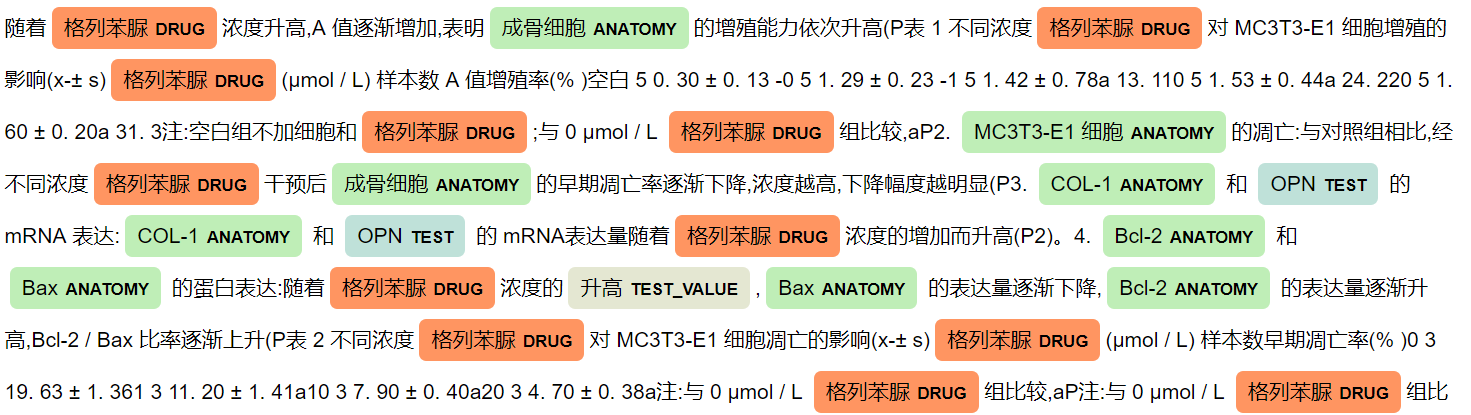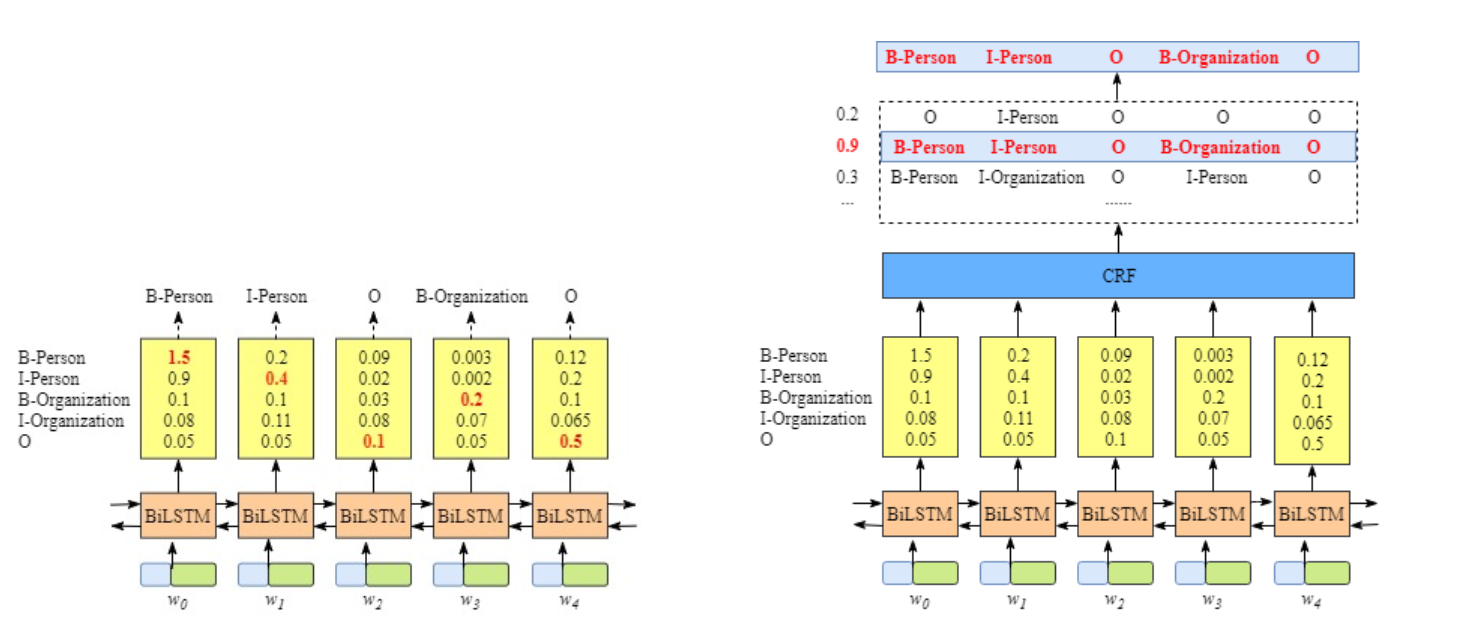

In [ ]:
import numpy as np
from sklearn.model_selection import ShuffleSplit
from gensim.models import Word2Vec
# from data_utils import ENTITIES, Documents, Dataset, SentenceExtractor, make_predictions
# from data_utils import Evaluator
# from models import build_lstm_crf_model

data_dir = './data/ner_example'
ent2idx = dict(zip(ENTITIES, range(1, len(ENTITIES) + 1)))
idx2ent = dict([(v, k) for k, v in ent2idx.items()])

docs = Documents(data_dir=data_dir)
rs = ShuffleSplit(n_splits=1, test_size=20, random_state=2018)
train_doc_ids, test_doc_ids = next(rs.split(docs))
train_docs, test_docs = docs[train_doc_ids], docs[test_doc_ids]

train_docs[0]

num_cates = max(ent2idx.values()) + 1
sent_len = 64
vocab_size = 3000
emb_size = 100
sent_pad = 10
sent_extrator = SentenceExtractor(window_size=sent_len, pad_size=sent_pad)
train_sents = sent_extrator(train_docs)
test_sents = sent_extrator(test_docs)

train_data = Dataset(train_sents, cate2idx=ent2idx)
train_data.build_vocab_dict(vocab_size=vocab_size)

test_data = Dataset(test_sents, word2idx=train_data.word2idx, cate2idx=ent2idx)
vocab_size = len(train_data.word2idx)


w2v_train_sents = []
for doc in docs:
    w2v_train_sents.append(list(doc.text))
w2v_model = Word2Vec(w2v_train_sents, size=emb_size)

w2v_embeddings = np.zeros((vocab_size, emb_size))
for char, char_idx in train_data.word2idx.items():
    if char in w2v_model.wv:
        w2v_embeddings[char_idx] = w2v_model.wv[char]

train_X, train_y = train_data[:]
print('train_X.shape', train_X.shape)
print('train_y.shape', train_y.shape)


train_X.shape (47577, 84)
train_y.shape (47577, 84, 1)


In [ ]:
seq_len = sent_len + 2 * sent_pad
model = build_lstm_crf_model(num_cates, seq_len=seq_len, vocab_size=vocab_size, 
                             model_opts={'emb_matrix': w2v_embeddings, 'emb_size': 100, 'emb_trainable': False})

model.summary()
history = model.fit(train_X, train_y, batch_size=64, epochs=1)

AttributeError: ignored

In [ ]:
# 预测结果
test_X, _ = test_data[:]
preds = model.predict(test_X, batch_size=64, verbose=True)
pred_docs = make_predictions(preds, test_data, sent_pad, docs, idx2ent)
f_score, precision, recall = Evaluator.f1_score(test_docs, pred_docs)
print('f_score: ', f_score)
print('precision: ', precision)
print('recall: ', recall)

sample_doc_id = list(pred_docs.keys())[0]
test_docs[sample_doc_id]
pred_docs[sample_doc_id]

In [ ]:
! pip install keras